## 对于从HORRIZAN上下载的数据，其只有坐标和速度，如何通过符号回归给出其加速度的函数表达式呢？
#### 根据某篇文献题到的方法，首先我们使用神经网络近似出数据集内的轨迹运动，即加速度的拆分一阶微分方程。通过这个微分方程，我们就可以得到加速度的近似值，从而去寻找函数表达式

### 1. 测试起见，我们使用之前训练好的微分方程。


In [10]:
import os
import torch
import torch.nn as nn
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

# 2. 定义ODE模型
class ODEFunc(nn.Module):
    def __init__(self):
        super(ODEFunc, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(4, 32),
            nn.Tanh(),
            nn.Linear(32, 32)  
        )
        self.fc1 = nn.Linear(32,20)
        self.fc2 = nn.Linear(20,4)

    def forward(self, t, y):
        y = self.net(y)
        y= torch.sin(y)
        y = self.fc1(y)
        y = torch.tanh(y)
        y = self.fc2(y)

        return y

model = ODEFunc()
model.load_state_dict(torch.load('../improved_data/xy_orbit_model_weights.pth'))

C:\Users\19464\AppData\Local\Temp\ipykernel_32320\2507323748.py:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('../improved_data/xy_orbit

<All keys matched successfully>

(4, 8760)


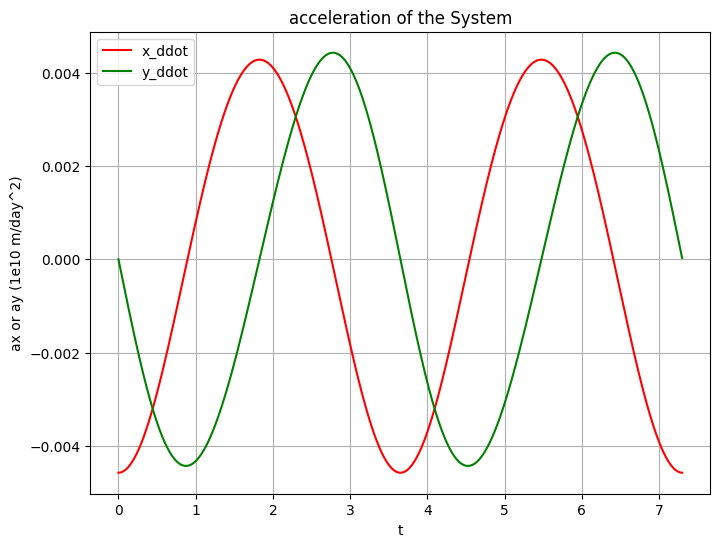

torch.Size([8760, 4])


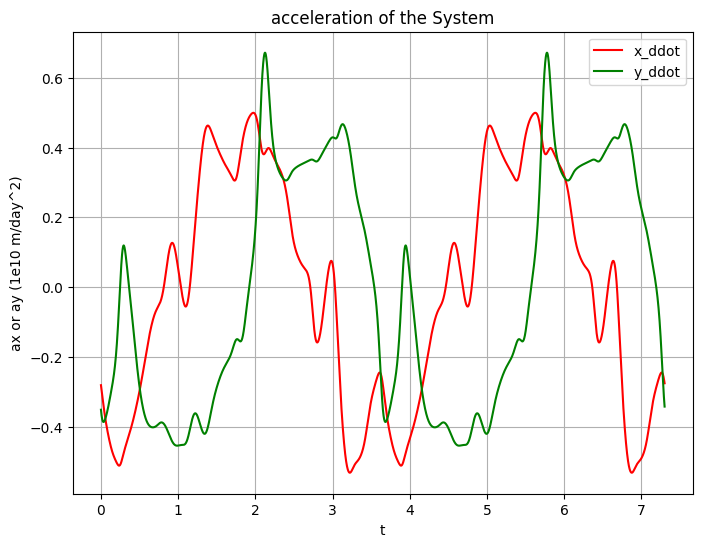

In [ ]:
# 比较一下数据差别

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1. 数据读取和预处理
# 加载数据
df = pd.read_csv('../improved_data/xy_orbit.csv')
array = df.to_numpy()
array = array.T
t = array[0]
yy = array[1:]/1e10

print(yy.shape)
# 提取坐标和速度，注意单位一致
x , y, vx, vy = yy[0], yy[1],  yy[2],  yy[3]

# 计算距离 r 和加速度分量
r = np.sqrt(x**2 + y**2)
G = 6.67430e-11 * 86400**2/1e30  # 引力常数, m^3 kg^-1 s^-2（调整单位）
M = 1.989e30  # 太阳质量
GM = G * M

# 加速度分量
x_ddot = -GM * x / r**3
y_ddot = -GM * y / r**3


plt.figure(figsize=(8, 6))
plt.plot(t,x_ddot, color = 'red',label = 'x_ddot')
plt.plot(t,y_ddot, color = 'green',label = 'y_ddot')
plt.xlabel('t')
plt.ylabel('ax or ay (1e10 m/day^2)')
plt.title('acceleration of the System')
plt.legend()
plt.grid()
plt.show()


# 根据模型计算出的加速度
yo = torch.tensor(yy.T, dtype=torch.float32)
t = torch.tensor(t,dtype = torch.float32)
tt = model.forward(t,yo)
pre = tt.detach().numpy()
print(yo.shape)

plt.figure(figsize=(8, 6))
plt.plot(t,pre[:,2], color = 'red',label = 'x_ddot')
plt.plot(t,pre[:,3], color = 'green',label = 'y_ddot')
plt.xlabel('t')
plt.ylabel('ax or ay (1e10 m/day^2)')
plt.title('acceleration of the System')
plt.legend()
plt.grid()
plt.show()





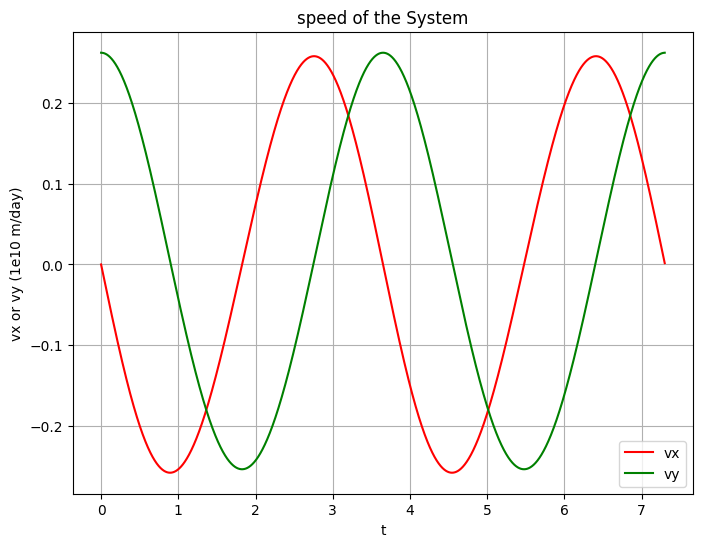

torch.Size([8760, 4])


C:\Users\19464\AppData\Local\Temp\ipykernel_32320\2779617138.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t,dtype = torch.float32)


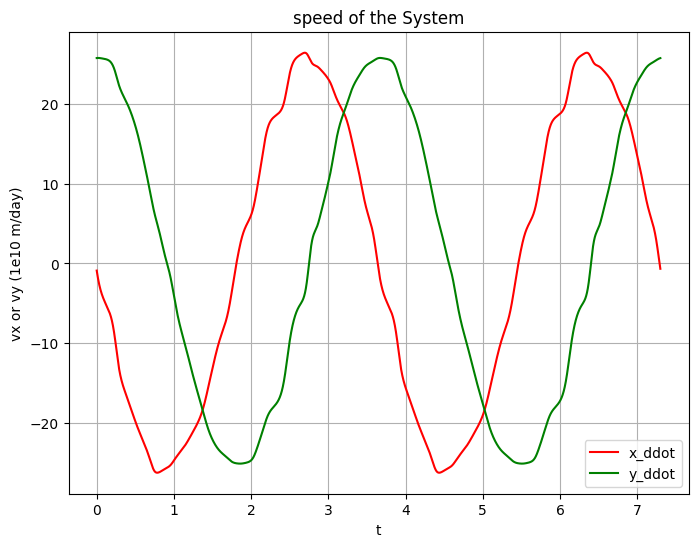

In [21]:
#比较一下速度分量
plt.figure(figsize=(8, 6))
plt.plot(t,vx, color = 'red',label = 'vx')
plt.plot(t,vy, color = 'green',label = 'vy')
plt.xlabel('t')
plt.ylabel('vx or vy (1e10 m/day)')
plt.title('speed of the System')
plt.legend()
plt.grid()
plt.show()

# 根据模型计算出的加速度
yo = torch.tensor(yy.T, dtype=torch.float32)
t = torch.tensor(t,dtype = torch.float32)
tt = model.forward(t,yo)
pre = tt.detach().numpy()
print(yo.shape)

plt.figure(figsize=(8, 6))
plt.plot(t,pre[:,0], color = 'red',label = 'x_ddot')
plt.plot(t,pre[:,1], color = 'green',label = 'y_ddot')
plt.xlabel('t')
plt.ylabel('vx or vy (1e10 m/day)')
plt.title('speed of the System')
plt.legend()
plt.grid()
plt.show()

## 检测另一个模型

In [23]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torchdiffeq import odeint  # 神经ODE库

df = pd.read_csv('../improved_data/xy_orbit.csv')
array = df.to_numpy()
array = array.T
t = array[0]/100
yy = array[1:]/1e10


#定义Stan激活函数
class StanActivation(nn.Module):
    def __init__(self, num_neurons):
        """
        初始化 Stan 激活函数。
        :param num_neurons: 每层的神经元数量，用于定义 beta 参数的大小
        """
        super(StanActivation, self).__init__()
        # 使用 nn.Parameter 初始化 beta，使其参与反向传播
        self.beta = nn.Parameter(torch.ones(num_neurons) * 0.1)  # 使用较小值初始化 beta
    
    def forward(self, x):
        """
        Stan 激活函数的前向计算
        :param x: 输入张量
        :return: 应用 Stan 激活函数后的输出张量
        """
        # 确保 beta 参与计算图
        return (1 + self.beta * x) * torch.tanh(x)

# 2. 定义ODE模型
class ODEFunc(nn.Module):
    def __init__(self):
        super(ODEFunc, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(4, 50),
            nn.Tanh(),
            nn.Linear(50, 50)  
        )
        self.fc1 = nn.Linear(50,30)
        self.stan = StanActivation(30)
        self.fc2 = nn.Linear(30,4)

    def forward(self, t, y):
        y = self.net(y)
        y= torch.sin(y)
        y = self.fc1(y)
        y = self.stan(y)
        y = self.fc2(y)

        return y

model = ODEFunc()
model.load_state_dict(torch.load('../improved_data/copy_model_params.pth'))

C:\Users\19464\AppData\Local\Temp\ipykernel_32320\2745116050.py:61: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('../improved_data/copy_mod

<All keys matched successfully>

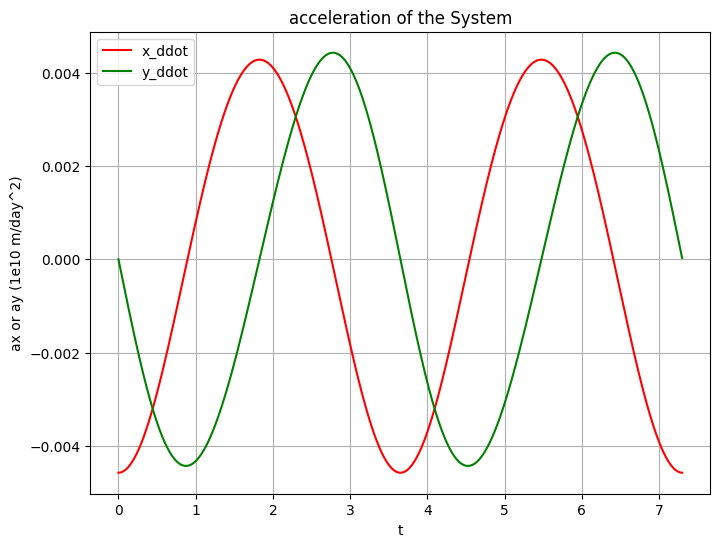

torch.Size([8760, 4])


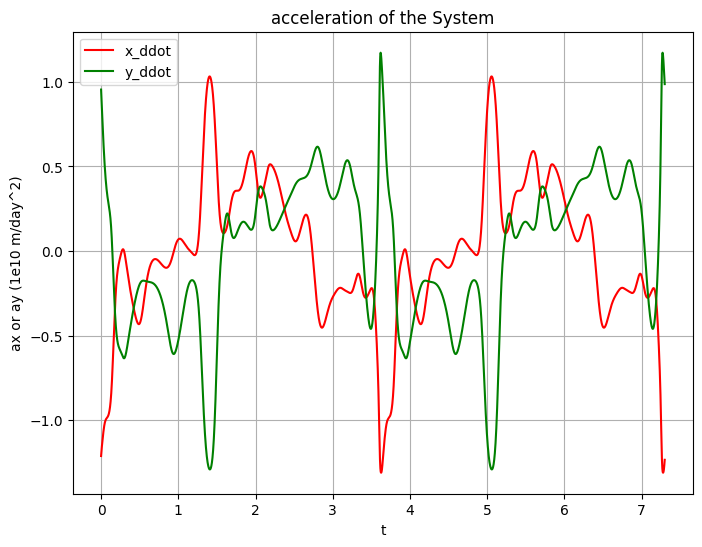

In [24]:
x , y, vx, vy = yy[0], yy[1],  yy[2],  yy[3]

# 计算距离 r 和加速度分量
r = np.sqrt(x**2 + y**2)
G = 6.67430e-11 * 86400**2/1e30  # 引力常数, m^3 kg^-1 s^-2（调整单位）
M = 1.989e30  # 太阳质量
GM = G * M

# 加速度分量
x_ddot = -GM * x / r**3
y_ddot = -GM * y / r**3


plt.figure(figsize=(8, 6))
plt.plot(t,x_ddot, color = 'red',label = 'x_ddot')
plt.plot(t,y_ddot, color = 'green',label = 'y_ddot')
plt.xlabel('t')
plt.ylabel('ax or ay (1e10 m/day^2)')
plt.title('acceleration of the System')
plt.legend()
plt.grid()
plt.show()


# 根据模型计算出的加速度
yo = torch.tensor(yy.T, dtype=torch.float32)
t = torch.tensor(t,dtype = torch.float32)
tt = model.forward(t,yo)
pre = tt.detach().numpy()
print(yo.shape)

plt.figure(figsize=(8, 6))
plt.plot(t,pre[:,2], color = 'red',label = 'x_ddot')
plt.plot(t,pre[:,3], color = 'green',label = 'y_ddot')
plt.xlabel('t')
plt.ylabel('ax or ay (1e10 m/day^2)')
plt.title('acceleration of the System')
plt.legend()
plt.grid()
plt.show()

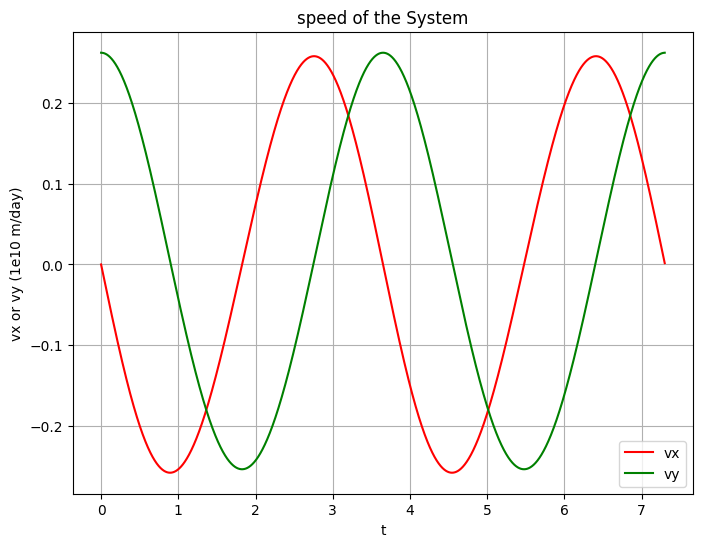

torch.Size([8760, 4])


C:\Users\19464\AppData\Local\Temp\ipykernel_32320\2779617138.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t,dtype = torch.float32)


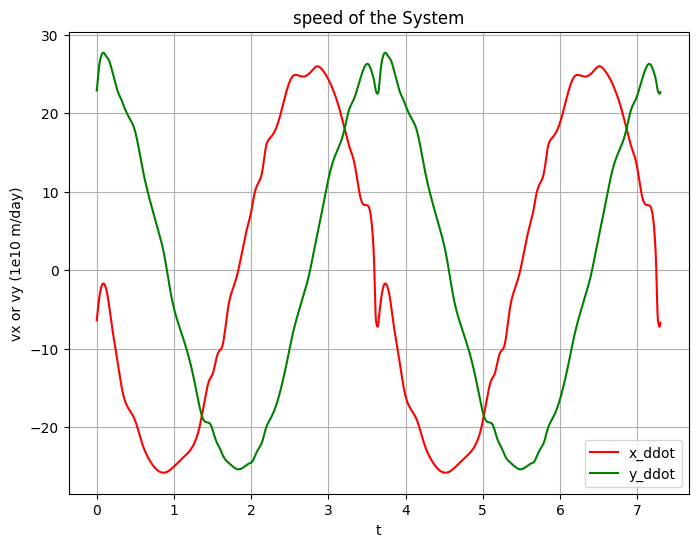

In [25]:
#比较一下速度分量
plt.figure(figsize=(8, 6))
plt.plot(t,vx, color = 'red',label = 'vx')
plt.plot(t,vy, color = 'green',label = 'vy')
plt.xlabel('t')
plt.ylabel('vx or vy (1e10 m/day)')
plt.title('speed of the System')
plt.legend()
plt.grid()
plt.show()

# 根据模型计算出的加速度
yo = torch.tensor(yy.T, dtype=torch.float32)
t = torch.tensor(t,dtype = torch.float32)
tt = model.forward(t,yo)
pre = tt.detach().numpy()
print(yo.shape)

plt.figure(figsize=(8, 6))
plt.plot(t,pre[:,0], color = 'red',label = 'x_ddot')
plt.plot(t,pre[:,1], color = 'green',label = 'y_ddot')
plt.xlabel('t')
plt.ylabel('vx or vy (1e10 m/day)')
plt.title('speed of the System')
plt.legend()
plt.grid()
plt.show()

## 观察下来发现，这个微分方程并非学习为二阶，故而需要重新训练一个网络。将方程确定为二阶。

In [1]:
## 1.学习一个微分方程

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torchdiffeq import odeint  # 神经ODE库

df = pd.read_csv('../improved_data/xy_orbit.csv')
array = df.to_numpy()
array = array.T
t = array[0]/100
y = array[1:]/1e10

coords = torch.tensor(y.T, dtype=torch.float32)
t_tensor = torch.tensor(t,dtype=torch.float32)

print(coords.shape)

#定义Stan激活函数
class StanActivation(nn.Module):
    def __init__(self, num_neurons):
        """
        初始化 Stan 激活函数。
        :param num_neurons: 每层的神经元数量，用于定义 beta 参数的大小
        """
        super(StanActivation, self).__init__()
        # 使用 nn.Parameter 初始化 beta，使其参与反向传播
        self.beta = nn.Parameter(torch.ones(num_neurons) * 0.1)  # 使用较小值初始化 beta
    
    def forward(self, x):
        """
        Stan 激活函数的前向计算
        :param x: 输入张量
        :return: 应用 Stan 激活函数后的输出张量
        """
        # 确保 beta 参与计算图
        return (1 + self.beta * x) * torch.tanh(x)

# 2. 定义ODE模型
class ODEFunc(nn.Module):
    def __init__(self):
        super(ODEFunc, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(4,40 ),
            nn.Tanh(),
            nn.Linear(40, 32)  
        )
        self.fc1 = nn.Linear(32,32)
        self.stan = StanActivation(num_neurons=32)
        self.fc2 = nn.Linear(32,2)
    
    # 初始化网络参数
        self._initialize_weights()

    def _initialize_weights(self):
        """ 高斯分布初始化函数 """
        # 定义初始化配置
        init_config = {
            'mean': 0.0,          # 均值
            'std_scale': 0.1,     # 标准差缩放系数（建议范围0.01~0.2）
            'bias_zero': True     # 是否将偏置初始化为0
        }

        # 遍历所有子模块
        for m in self.modules():
            if isinstance(m, nn.Linear):
                # 计算标准差（根据输入维度调整）
                fan_in = m.weight.size(1)
                std = init_config['std_scale'] / np.sqrt(fan_in)
                
                # 初始化权重
                nn.init.normal_(m.weight, 
                               mean=init_config['mean'],
                               std=std)
                
                # 初始化偏置
                if m.bias is not None:
                    if init_config['bias_zero']:
                        nn.init.constant_(m.bias, 0)
                    else:
                        nn.init.normal_(m.bias, 
                                      mean=init_config['mean'],
                                      std=std)

    def forward(self,t, y):
        y2 = self.net(y)
        y2 = self.stan(y2)
        y2 = self.fc1(y2)
        y2= torch.sin(y2)
        y2 = self.fc2(y2)
        return torch.cat([y[2].unsqueeze(0),  y[3].unsqueeze(0), y2[0].unsqueeze(0), y2[1].unsqueeze(0)])
    

# 早停用函数
def errors(data):
    mean_value = np.mean(data)
    errors = data - mean_value
    absolute_errors = np.abs(errors)
    mae = np.mean(absolute_errors)
    return mae


# 初始条件
G = 6.67430e-11  # 引力常数, m^3 kg^-1 s^-2
M = 1.989e30     # 太阳质量, kg
#r0 = [1.496e11, 0]#初始位置 m
#v0 = [0,30.29e3 ] #初始速度 m/s
#m = 5.972e24     # 地球质量 kg
print(y.shape)

#统一单位
G = G*86400**2 / 1e30
#r0 =r0/1e10
#v0 = v0 * 86400 / 1e10

def energy(Y, G, M):
    x, y, vx, vy = Y[:,0],Y[:,1],Y[:,2],Y[:,3]
    K = (vx**2 + vy**2)/2 - G*M/torch.sqrt(x**2 + y**2)
    return K

def angle(Y,G,M):
    x, y, vx, vy = Y[:,0],Y[:,1],Y[:,2],Y[:,3]
    l = x*vy-y*vx
    return l

energy0 = energy(coords,G,M)
angle0 = angle(coords,G,M)

print(energy0,angle0)
print(energy0.shape,angle0.shape)

class CustomLoss:
    def __init__(self, alpha=0.1, beta=0.1):
        self.alpha = alpha
        self.beta = beta

    def __call__(self, y, y_target):
        trajectory_loss = torch.mean((y - y_target)**2)
        energy_loss = torch.mean((energy(y,G,M)-energy0)**2)
        angle_loss = torch.mean((angle(y,G,M)-angle0)**2)
        if self.alpha != 0 and self.beta != 0:
            return trajectory_loss  + self.alpha * energy_loss + self.beta * angle_loss
        if self.alpha == 0 and self.beta != 0:
            return trajectory_loss  + self.beta * angle_loss
        if self.beta == 0 and self.alpha != 0:
            return trajectory_loss  + self.alpha * energy_loss
        if self.beta == 0 and self.alpha == 0:
            return trajectory_loss
        
# 超参数设置
loss_value = []
mini_delta = 0.005
sum_ = np.array([0,0,0,0,0])

# 定义训练函数
def train(model,optimizer,criterion,epochs):
    model.train()
    for epoch in range(epochs+1):
        optimizer.zero_grad()
        
        # 神经ODE求解
        pred_y = odeint(model, coords[0], t_tensor)
        
        # 计算损失
        loss = criterion(pred_y, coords)
        
        # 反向传播和优化
        loss.backward()
        optimizer.step()
        
        # 打印损失
        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item()}")

        #设置早停
        loss_value.append(loss.item())
        if epoch > 5:
            for i in range(5):
                sum_[i] = loss_value[epoch]-loss_value[epoch-i-1]
        err = errors(sum_)

        if epoch == epochs:
            torch.save(model.state_dict(), 'ax_ay_model_params.pth')

        if loss.item() < 0.01 and err < 0.001 :
            torch.save(model.state_dict(), 'ax_ay_model_params.pth')
            break

torch.Size([8760, 4])
(4, 8760)
tensor([-0.0331, -0.0331, -0.0331,  ..., -0.0331, -0.0331, -0.0331]) tensor([3.8497, 3.8497, 3.8497,  ..., 3.8497, 3.8497, 3.8497])
torch.Size([8760]) torch.Size([8760])


In [6]:
#设置训练：
model = ODEFunc()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
epochs = 500
loss = CustomLoss(0,0)

In [ ]:
train(model,optimizer,loss,epochs)

In [ ]:

checkpoint = {
    'model': model.state_dict(),
    'optimizer': optimizer.state_dict(),
    'epoch': epochs
}
torch.save(checkpoint, 'checkpoint.pth')

In [ ]:

model = ODEFunc()
optimizer = optim.Adam(model.parameters(), lr=0.001)

checkpoint_path = 'checkpoint.pth'
# 2. 恢复模型和优化器状态
model.load_state_dict(checkpoint['model'])
optimizer.load_state_dict(checkpoint['optimizer'])

# 3. 恢复其他训练状态
start_epoch = checkpoint['epoch'] + 1  # 从下一个epoch开始
best_val_loss = checkpoint.get('best_val_loss', float('inf'))  # 兼容旧版本检查点


epochs = 1000
loss = CustomLoss(0,0)

train(model,optimizer,loss,epochs)

In [ ]:
train(model,optimizer,loss,epochs)

In [8]:

# 使用DeepSpeed的Adan（支持max_grad_norm）

checkpoint_path = 'checkpoint.pth'
# 2. 恢复模型和优化器状态
model.load_state_dict(checkpoint['model'])
# 3. 恢复其他训练状态
start_epoch = checkpoint['epoch'] + 1  # 从下一个epoch开始
epochs = 1000
loss = CustomLoss(0,0)

train(model,optimizer,loss,epochs)

TypeError: Adan.__init__() got an unexpected keyword argument 'max_grad_norm'